In [19]:
import pandas as pd
import quandl
import matplotlib.pylab as plt

import sys

In [24]:
!{sys.executable} -m pip install matplotlib

In [56]:
#importing Tesla (TSLA) financial data from quandl
tesla = quandl.get('WIKI/TSLA')

#importing GM (GM) financial data from quandl
gm = quandl.get('WIKI/GM')
gm.head(5)

#importing Apple (APPL) data from quandl
apple = quandl.get('WIKI/AAPL')

#importing Microsoft (MSFT) data from quandl
microsoft = quandl.get('WIKI/MSFT')

print(tesla)

              Open      High     Low   Close      Volume  Ex-Dividend  \
Date                                                                    
2010-06-29   19.00   25.0000   17.54   23.89  18766300.0          0.0   
2010-06-30   25.79   30.4192   23.30   23.83  17187100.0          0.0   
2010-07-01   25.00   25.9200   20.27   21.96   8218800.0          0.0   
2010-07-02   23.00   23.1000   18.71   19.20   5139800.0          0.0   
2010-07-06   20.00   20.0000   15.83   16.11   6866900.0          0.0   
...            ...       ...     ...     ...         ...          ...   
2018-03-21  310.25  322.4400  310.19  316.53   5927881.0          0.0   
2018-03-22  313.89  318.8200  308.18  309.10   4914307.0          0.0   
2018-03-23  311.25  311.6100  300.45  301.54   6600538.0          0.0   
2018-03-26  307.34  307.5900  291.36  304.18   8324639.0          0.0   
2018-03-27  304.00  304.2700  277.18  279.18  13696168.0          0.0   

            Split Ratio  Adj. Open  Adj. High  Adj

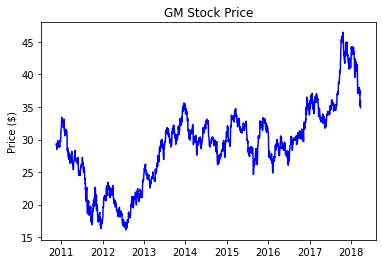

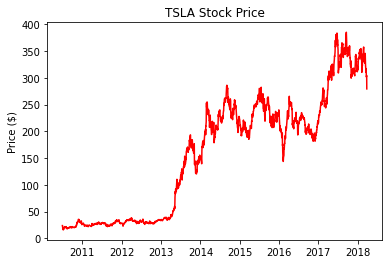

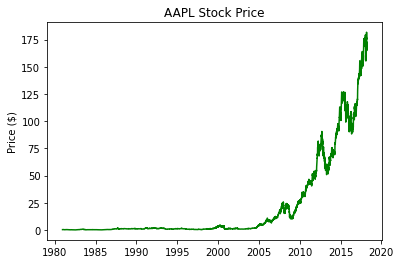

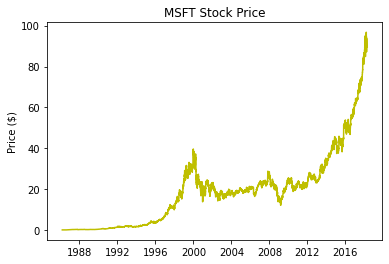

In [30]:
plt.plot(gm.index, gm['Adj. Close'], 'b')
plt.title('GM Stock Price')
plt.ylabel('Price ($)')
plt.show()

plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('TSLA Stock Price')
plt.ylabel('Price ($)')
plt.show()

plt.plot(apple.index, apple['Adj. Close'], 'g')
plt.title('AAPL Stock Price')
plt.ylabel('Price ($)')
plt.show()

plt.plot(microsoft.index, microsoft['Adj. Close'], 'y')
plt.title('MSFT Stock Price')
plt.ylabel('Price ($)')
plt.show()

In [55]:
#yearly average number of shares outstanding for TSLA and GM
#extraced from

#print((0.254+0.461+0.038+0.037)/4)

#print(tesla)

tesla_shares = {
    2018: 0.859e9, 2017: 0.82575e9, 2016: 0.717e9, 2015: 0.63725e9, 2014: 0.6215e9, 
    2013: 0.6295e9, 2012: 0.52875e9, 2011: 0.518e9 , 2010: 0.1975e9}

#gm_shares = {2018:, 2017:, 2016:, 2015:, 2014:, 2013:, 2012:, 2011:, 2010:}

#yearly average number of shars outstanding for AAPL and MSFT

tesla['Year'] = tesla.index.year

tesla.reset_index(level=0, inplace = True)
tesla['cap'] = 0

#calculate market caps by year
for i, year in enumerate(tesla['Year']):
    shares = tesla_shares.get(year)
    
    tesla.iloc[i, 'cap'] = shares*tesla.iloc[i, 'Adj. Close']

AttributeError: 'RangeIndex' object has no attribute 'year'